# SCNIEC+

This notebook runs the SCENIC+ framework for unpaired scRNA-seq and scATAC-seq on the tumor cells from the Spermatogenesis Mouse dataset 

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
sys.path.append('/home/sussmanj/miniconda3/envs/scenicplus/lib/')
_stderr = sys.stderr
null = open(os.devnull,'wb')

%matplotlib inline

In [2]:
import importlib
import sys
import os 
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.loom import *
from scenicplus.preprocessing.filtering import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import evaluate_models
from pycisTopic.clust_vis import run_umap
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import pickle
import dill
from pycisTopic.clust_vis import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycisTopic.lda_models import run_cgs_models_mallet
import scipy.sparse as sp
import scipy.io as spio
import pyranges as pr
import numpy as  np
from pycistarget.utils import region_names_to_coordinates
from pycisTopic.lda_models import run_cgs_models
from scenicplus.wrappers.run_pycistarget import run_pycistarget
import pybiomart as pbm
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.eregulon_enrichment import score_eRegulons
import seaborn as sns
from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
import seaborn as sns
import sklearn
from scenicplus.differentiation_potential import *
import mudata
from scenicplus.scenicplus_class import *

/home/sussmanj/miniconda3/envs/ScenicPlus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-08 16:11:26,970	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
out_dir = "/mnt/isilon/tan_lab/sussmanj/Temp/ETP_ALL/SCENICPlus/SCENICPlus_Pipeline/Output_BMP_TSpec_Final//"
scplus_mdata = mudata.read(out_dir + "/scplusmdata.h5mu")

In [6]:
scplus_mdata.uns["direct_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr1:38026552-38031143,UTP11,0.055388,0.108265,0.005997,0.005997,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.122617,1,0.090690,7547
1,chr6:110527885-110530011,AMD1,0.015537,0.254111,0.003948,0.003948,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.326137,1,0.228242,26994
2,chr19:48627009-48627595,EMP3,0.019393,0.342949,0.006651,0.006651,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),3.427309,1,0.326175,10453
3,chr17:81577312-81580264,ACTG1,0.060192,0.384890,0.023167,0.023167,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),5.632475,1,0.436210,539
4,chr17:77834059-77835076,TMC8,0.012874,0.102318,0.001317,0.001317,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.595931,1,0.110824,20919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32527,chr11:64564458-64567417,DNAJC4,0.023810,-0.079709,-0.001898,0.001898,ZNF519,False,ZNF519_direct_-/-,ZNF519_direct_-/-_(11g),ZNF519_direct_-/-_(11r),0.422783,-1,-0.055062,19995
32528,chr6:106509344-106514256,RTN4IP1,0.041663,-0.045870,-0.001911,0.001911,ZNF519,False,ZNF519_direct_-/-,ZNF519_direct_-/-_(11g),ZNF519_direct_-/-_(11r),0.328796,-1,-0.047766,17507
32529,chr19:12837133-12841329,TRMT1,0.014223,-0.037998,-0.000540,0.000540,ZNF519,False,ZNF519_direct_-/-,ZNF519_direct_-/-_(11g),ZNF519_direct_-/-_(11r),0.614343,-1,-0.065103,24847
32530,chr11:77993888-77995482,AAMDC,0.024606,-0.032984,-0.000812,0.000812,ZNF519,False,ZNF519_direct_-/-,ZNF519_direct_-/-_(11g),ZNF519_direct_-/-_(11r),0.151580,-1,-0.046051,29696


In [7]:
scplus_mdata.uns["extended_e_regulon_metadata"]

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr16:30774905-30776929,ZNF768,0.023775,0.037109,0.000882,0.000882,CEBPE,True,CEBPE_extended_+/+,CEBPE_extended_+/+_(18g),CEBPE_extended_+/+_(21r),2.533502,1,0.042403,3311
1,chr22:19643401-19645834,TRMT2A,0.020189,0.065241,0.001317,0.001317,CEBPE,True,CEBPE_extended_+/+,CEBPE_extended_+/+_(18g),CEBPE_extended_+/+_(21r),1.036118,1,0.042153,1796
2,chr11:223976-226483,SIRT3,0.032685,0.051975,0.001699,0.001699,CEBPE,True,CEBPE_extended_+/+,CEBPE_extended_+/+_(18g),CEBPE_extended_+/+_(21r),2.286865,1,0.071470,1634
3,chr15:66144850-66147822,DIS3L,0.030623,0.049392,0.001513,0.001513,CEBPE,True,CEBPE_extended_+/+,CEBPE_extended_+/+_(18g),CEBPE_extended_+/+_(21r),1.279696,1,0.057863,5636
4,chr8:120856917-120858144,SNTB1,0.036874,0.072686,0.002680,0.002680,CEBPE,True,CEBPE_extended_+/+,CEBPE_extended_+/+_(18g),CEBPE_extended_+/+_(21r),0.995484,1,0.040754,4847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14384,chr5:134435397-134437764,UBE2B,0.062735,-0.473034,-0.029676,0.029676,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),3.693407,-1,-0.361642,214
14385,chr10:98339508-98341395,HPS1,0.053672,-0.151384,-0.008125,0.008125,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),1.298456,-1,-0.112419,264
14386,chr19:3670223-3672684,DOHH,0.025726,-0.132292,-0.003403,0.003403,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),4.085291,-1,-0.150990,681
14387,chr11:57353826-57356697,MED19,0.026517,-0.108230,-0.002870,0.002870,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),1.347694,-1,-0.068030,4723


In [8]:
scplus_mdata

MuData object with n_obs × n_vars = 5164 × 221654
  uns:	'direct_e_regulon_metadata', 'extended_e_regulon_metadata'
  6 modalities
    scRNA_counts:	5164 x 33538
      obs:	'comparison.bmp.vs.t.specified'
    scATAC_counts:	5164 x 187952
      obs:	'comparison.bmp.vs.t.specified'
      var:	'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    direct_gene_based_AUC:	5164 x 48
    direct_region_based_AUC:	5164 x 48
    extended_gene_based_AUC:	5164 x 34
    extended_region_based_AUC:	5164 x 34

In [9]:
apply_std_filtering_to_eRegulons(scplus_mdata)

2024-05-08 16:12:11,795 Preprocessing INFO     Only keeping positive region-to-gene links
2024-05-08 16:12:11,805 Preprocessing INFO     Only keep extended inf not direct


In [10]:
scplus_mdata.uns['e_regulon_metadata_filtered']

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr1:38026552-38031143,UTP11,0.055388,0.108265,0.005997,0.005997,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.122617,1,0.090690,7547
1,chr6:110527885-110530011,AMD1,0.015537,0.254111,0.003948,0.003948,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.326137,1,0.228242,26994
2,chr19:48627009-48627595,EMP3,0.019393,0.342949,0.006651,0.006651,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),3.427309,1,0.326175,10453
3,chr17:81577312-81580264,ACTG1,0.060192,0.384890,0.023167,0.023167,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),5.632475,1,0.436210,539
4,chr17:77834059-77835076,TMC8,0.012874,0.102318,0.001317,0.001317,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.595931,1,0.110824,20919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10298,chr2:65162797-65166081,RAB1A,0.010612,0.030600,0.000325,0.000325,ZNF518A,True,ZNF518A_extended_-/+,ZNF518A_extended_-/+_(19g),ZNF518A_extended_-/+_(22r),0.258350,-1,-0.049944,13288
10299,chr20:44978145-44980516,STK4,0.026339,0.047305,0.001246,0.001246,ZNF518A,True,ZNF518A_extended_-/+,ZNF518A_extended_-/+_(19g),ZNF518A_extended_-/+_(22r),0.278753,-1,-0.069276,9890
10300,chr7:143292849-143293356,ZYX,0.025839,0.166681,0.004307,0.004307,ZNF518A,True,ZNF518A_extended_-/+,ZNF518A_extended_-/+_(19g),ZNF518A_extended_-/+_(22r),0.256707,-1,-0.087347,6702
10301,chr16:11741756-11744156,TXNDC11,0.023811,0.044254,0.001054,0.001054,ZNF518A,True,ZNF518A_extended_-/+,ZNF518A_extended_-/+_(19g),ZNF518A_extended_-/+_(22r),0.429149,-1,-0.048118,6313


In [11]:
scplus_mdata.uns['e_regulon_metadata_filtered'].to_csv(out_dir+'eRegulon_filtered.tsv', sep='\t', index=False)

In [12]:
eRegulon_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"], 
    scplus_mdata["direct_region_based_AUC"], scplus_mdata["extended_region_based_AUC"]],
    axis = 1,
)
eRegulon_AUC.obs = scplus_mdata.obs.loc[eRegulon_AUC.obs_names]

In [13]:
eRegulon_AUC.write(out_dir+'eGRN_AUC.h5ad')

In [ ]:
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "scATAC_counts:comparison.bmp.vs.t.specified",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (23, 5), 
    save = out_dir+'heatmap.png'
)

In [13]:
rss_gene = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scATAC_counts:comparison.bmp.vs.t.specified",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"], 
    selected_regulons = np.unique(scplus_mdata.uns['e_regulon_metadata_filtered']['Gene_signature_name']),
)

In [139]:
help(plot_rss)

Help on function plot_rss in module scenicplus.RSS:

plot_rss(data_matrix: pandas.core.frame.DataFrame, top_n: int = 5, selected_groups: List[str] = None, num_columns: int = 1, figsize: Tuple[float, float] = (6.4, 4.8), fontsize: int = 12, save: str = None)
    Plot RSS values per group
    
    Parameters
    ---------
    data_matrix: `class::pd.DataFrame`
        A pandas dataframe with RSS scores per variable.
    top_n: int, optional
        Number of top eRegulons to highlight.
    selected_groups: List, optional
        Groups to plot. Default: None (all)
    num_columns: int, optional
        Number of columns for multiplotting
    figsize: tuple, optional
        Size of the figure. If num_columns is 1, this is the size for each figure;
        if num_columns is above 1, this is the overall size of the figure (if keeping
        default, it will be the size of each subplot in the figure). Default: (6.4, 4.8)
    fontsize: int, optional
        Size of the eRegulons names in pl

2024-04-28 15:23:40,809 fontTools.subset INFO     maxp pruned
2024-04-28 15:23:40,819 fontTools.subset INFO     cmap pruned
2024-04-28 15:23:40,819 fontTools.subset INFO     kern dropped
2024-04-28 15:23:40,820 fontTools.subset INFO     post pruned
2024-04-28 15:23:40,820 fontTools.subset INFO     FFTM dropped
2024-04-28 15:23:40,822 fontTools.subset INFO     GPOS pruned
2024-04-28 15:23:40,826 fontTools.subset INFO     GSUB pruned
2024-04-28 15:23:40,833 fontTools.subset INFO     glyf pruned
2024-04-28 15:23:40,835 fontTools.subset INFO     Added gid0 to subset
2024-04-28 15:23:40,835 fontTools.subset INFO     Added first four glyphs to subset
2024-04-28 15:23:40,835 fontTools.subset INFO     Closing glyph list over 'GSUB': 58 glyphs before
2024-04-28 15:23:40,836 fontTools.subset INFO     Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'V', 'X', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'hyphen', 'i',

2024-04-28 15:23:40,908 fontTools.subset INFO     name pruned


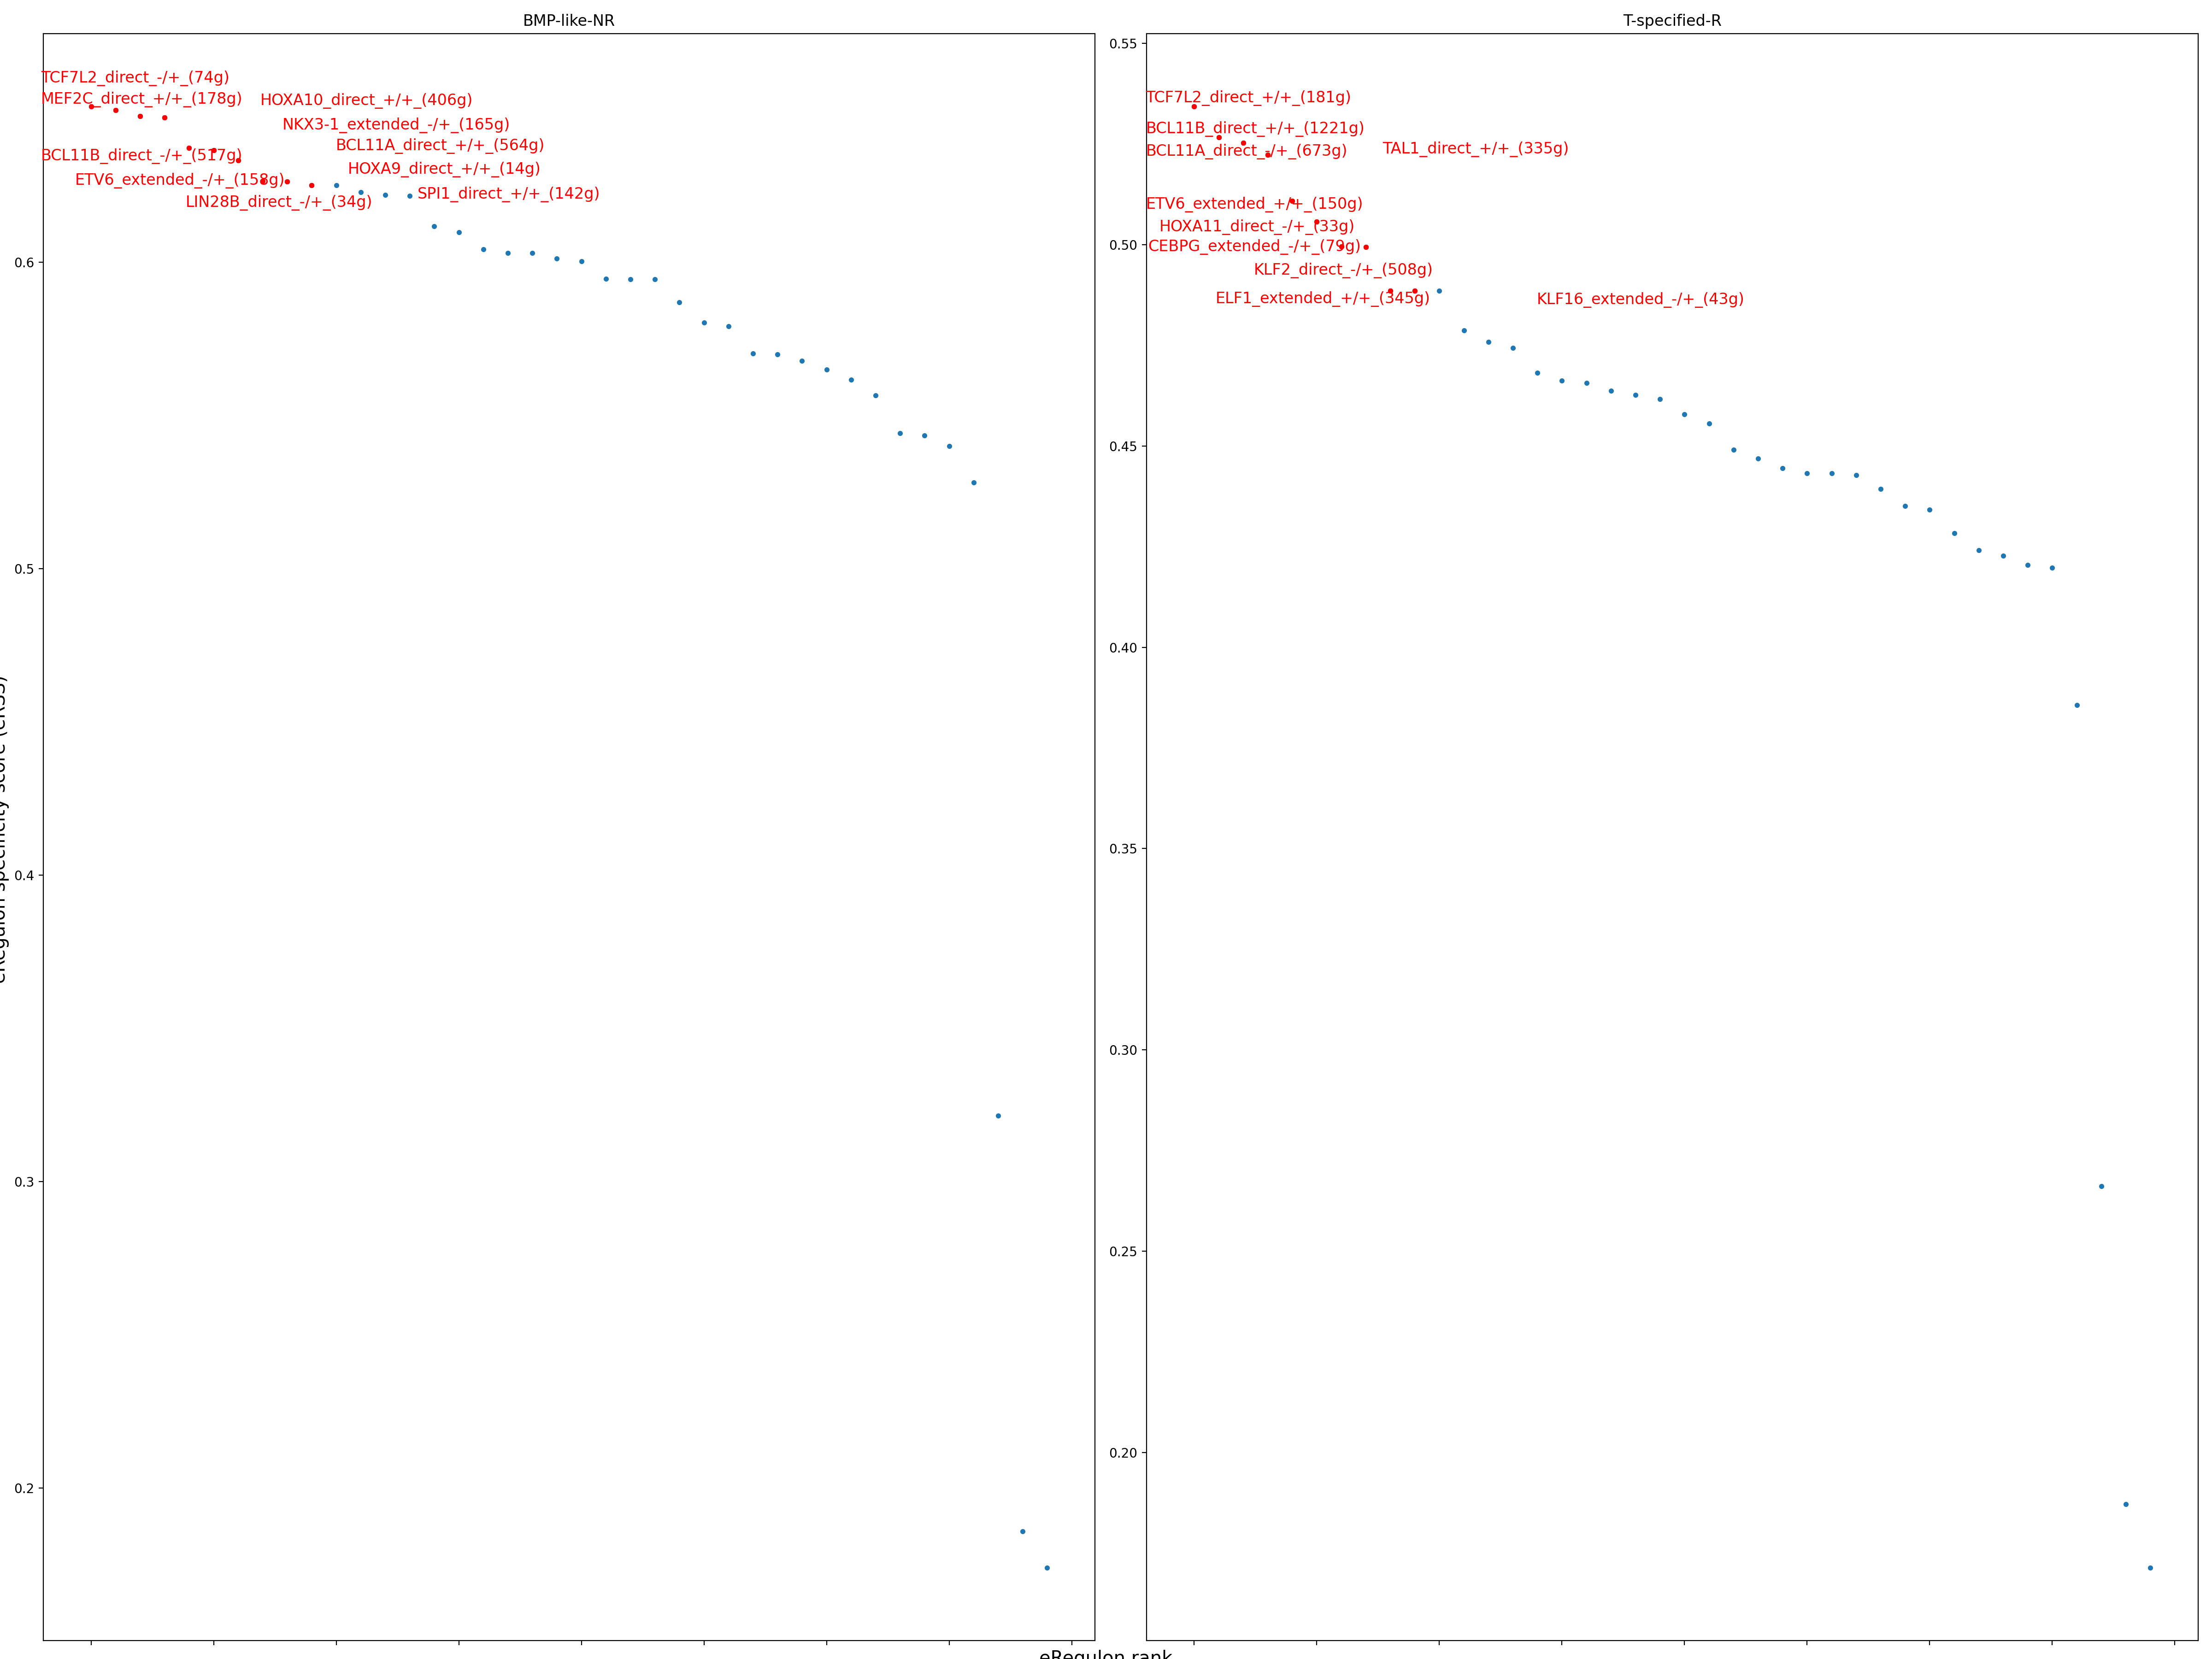

In [149]:
plot_rss(
    data_matrix = rss_gene,
    top_n = 10,
    num_columns = 2, 
    figsize = (12,18),
    save = 'Gene_RSS.pdf'
)

In [15]:
rss_region = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "scATAC_counts:comparison.bmp.vs.t.specified",
    modalities = ["direct_region_based_AUC", "extended_region_based_AUC"], 
    selected_regulons = np.unique(scplus_mdata.uns['e_regulon_metadata_filtered']['Region_signature_name']),
)

2024-04-28 15:25:02,283 fontTools.subset INFO     maxp pruned
2024-04-28 15:25:02,292 fontTools.subset INFO     cmap pruned
2024-04-28 15:25:02,293 fontTools.subset INFO     kern dropped
2024-04-28 15:25:02,294 fontTools.subset INFO     post pruned
2024-04-28 15:25:02,294 fontTools.subset INFO     FFTM dropped
2024-04-28 15:25:02,297 fontTools.subset INFO     GPOS pruned
2024-04-28 15:25:02,301 fontTools.subset INFO     GSUB pruned
2024-04-28 15:25:02,308 fontTools.subset INFO     glyf pruned
2024-04-28 15:25:02,309 fontTools.subset INFO     Added gid0 to subset
2024-04-28 15:25:02,310 fontTools.subset INFO     Added first four glyphs to subset
2024-04-28 15:25:02,310 fontTools.subset INFO     Closing glyph list over 'GSUB': 61 glyphs before
2024-04-28 15:25:02,310 fontTools.subset INFO     Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g',

2024-04-28 15:25:02,359 fontTools.subset INFO     GDEF pruned
2024-04-28 15:25:02,359 fontTools.subset INFO     GPOS pruned
2024-04-28 15:25:02,360 fontTools.subset INFO     GSUB pruned
2024-04-28 15:25:02,373 fontTools.subset INFO     name pruned


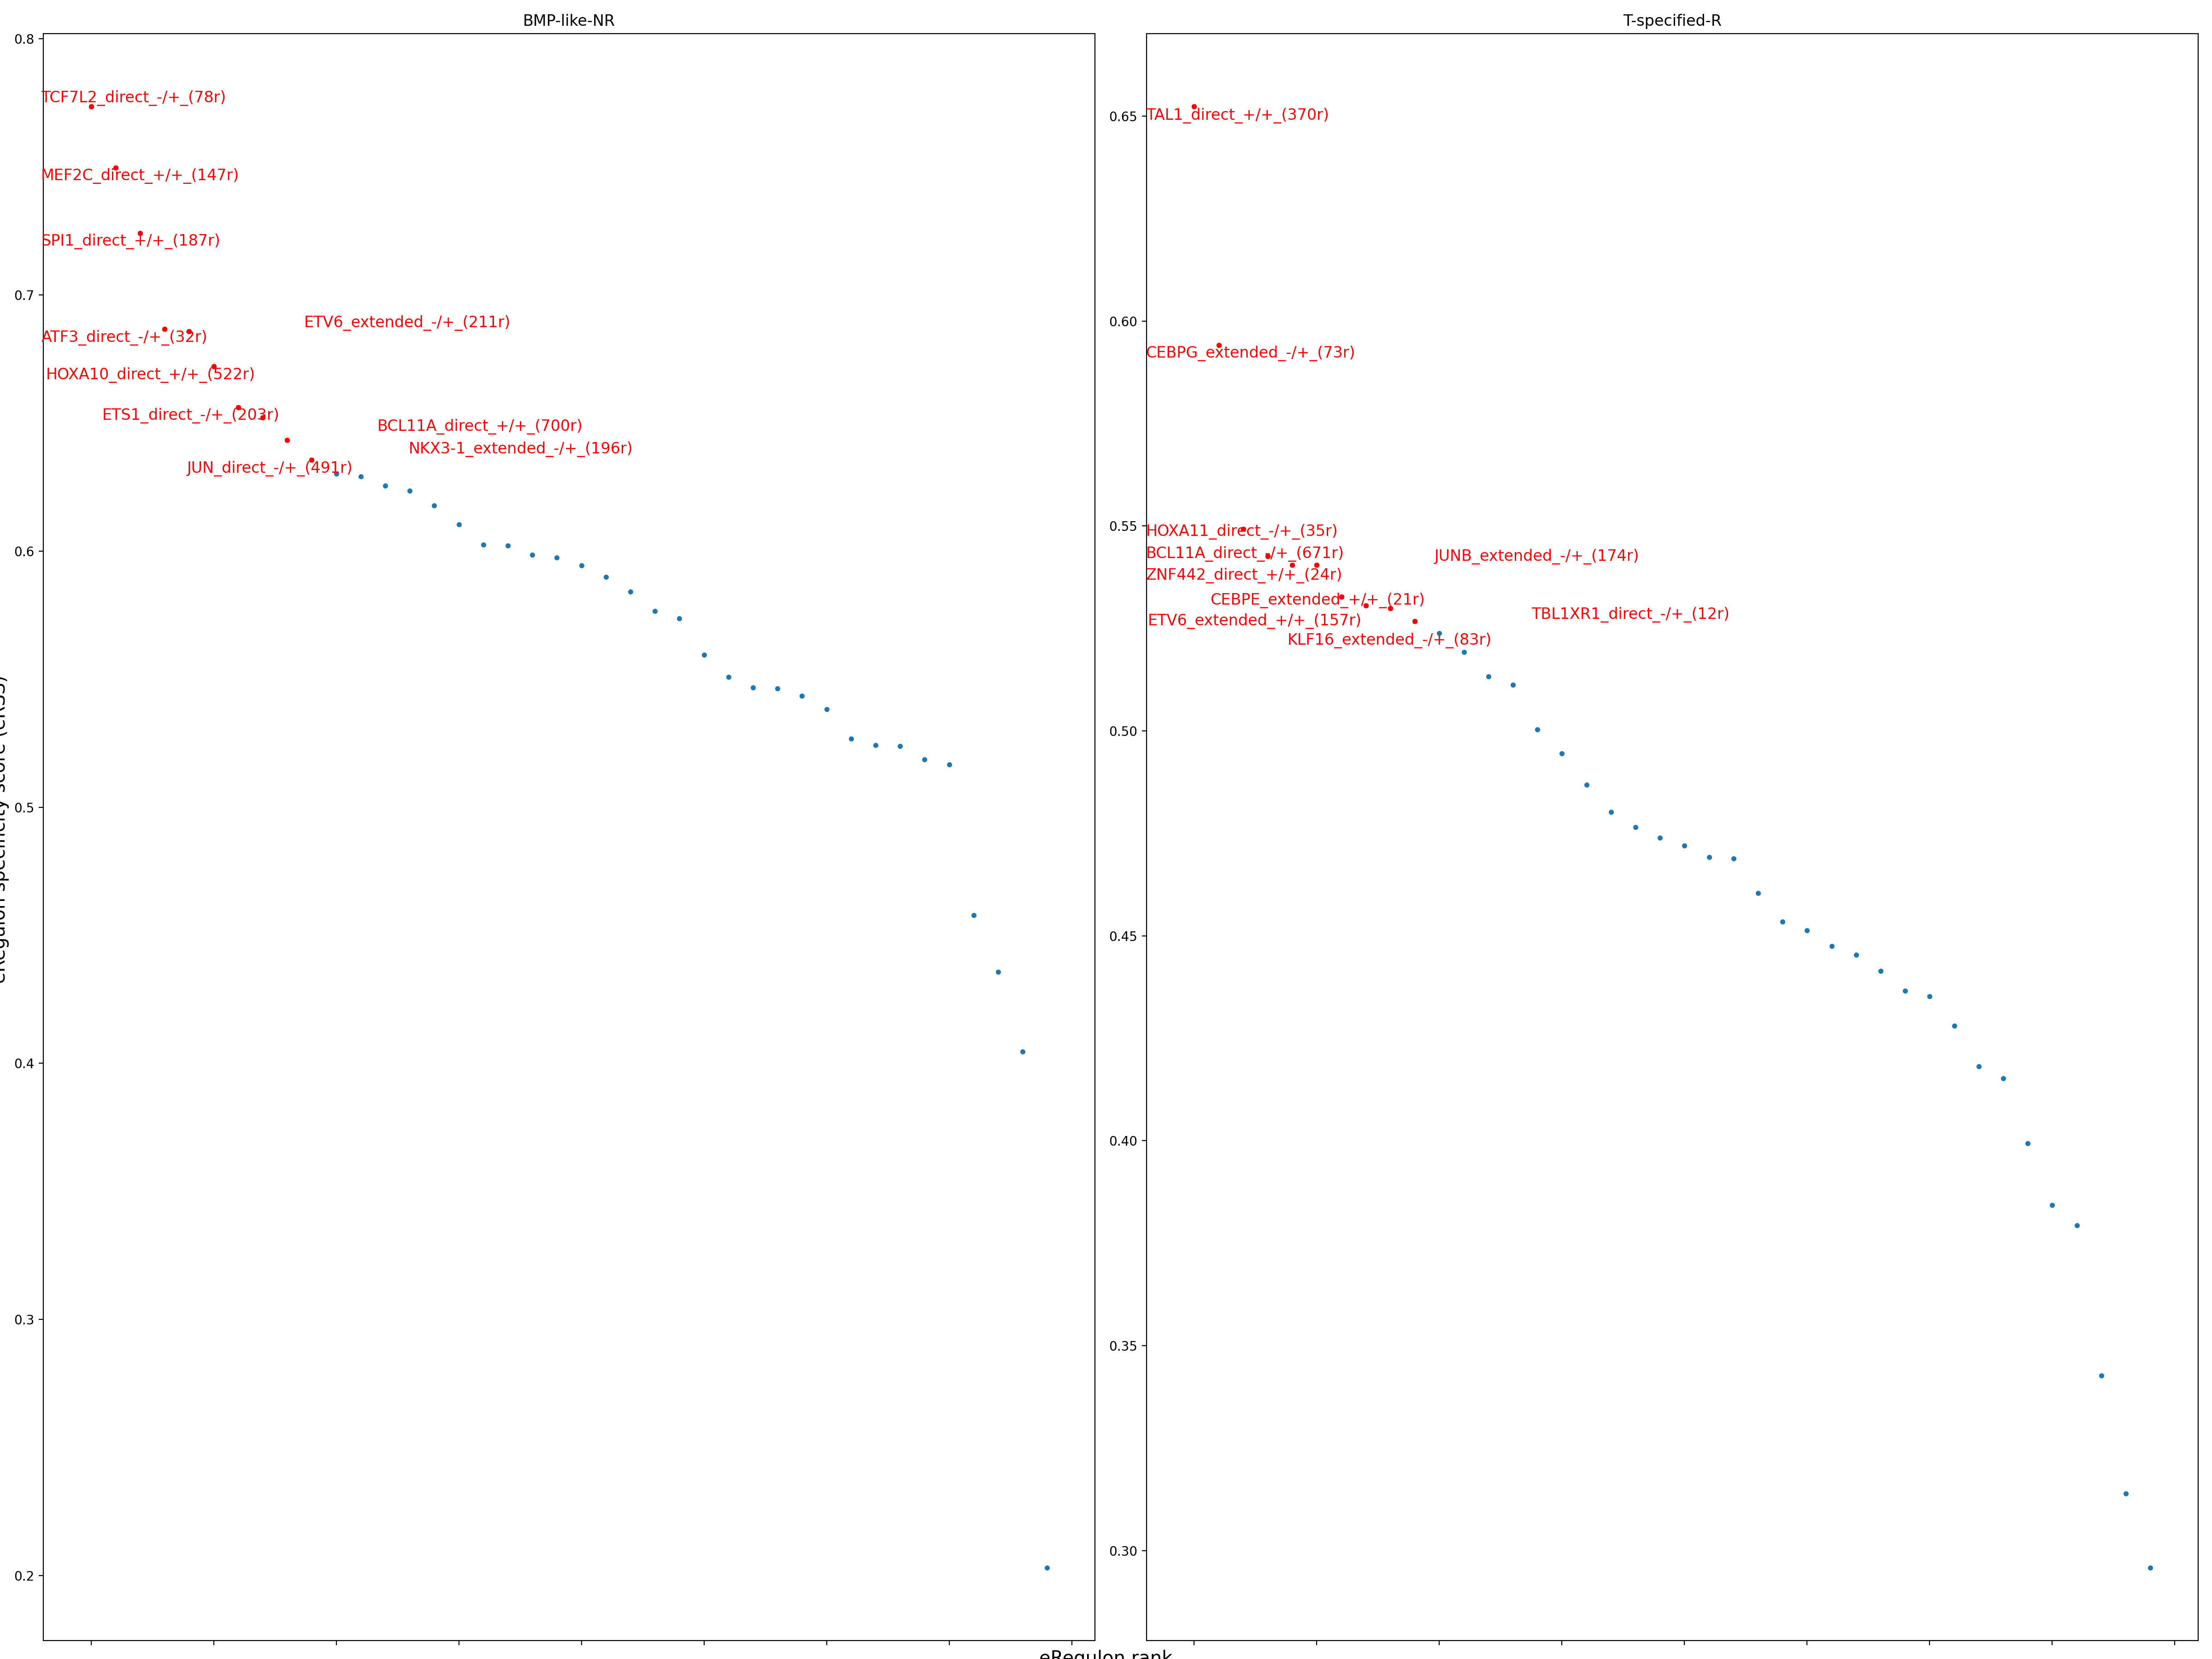

In [150]:
plot_rss(
    data_matrix = rss_region,
    top_n = 10,
    num_columns = 2, 
    figsize = (12,18), 
    save = "Region_RSS.pdf"
)

Graphing a Network

In [14]:
scplus_obj = mudata_to_scenicplus(mdata = scplus_mdata, 
                                  path_to_cistarget_h5 = out_dir + "/ctx_results.hdf5", 
                                 path_to_dem_h5 = out_dir + "/dem_results.hdf5")

In [15]:
apply_std_filtering_to_eRegulons(scplus_obj)

2024-05-08 16:13:20,921 Preprocessing INFO     Only keeping positive region-to-gene links


In [16]:
scplus_obj.uns['eRegulon_metadata']

,Region,Gene,importance_R2G,rho_R2G,importance_x_rho,importance_x_abs_rho,TF,is_extended,eRegulon_name,Gene_signature_name,Region_signature_name,importance_TF2G,regulation,rho_TF2G,triplet_rank
0,chr1:38026552-38031143,UTP11,0.055388,0.108265,0.005997,0.005997,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.122617,1,0.090690,7547
1,chr6:110527885-110530011,AMD1,0.015537,0.254111,0.003948,0.003948,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.326137,1,0.228242,26994
2,chr19:48627009-48627595,EMP3,0.019393,0.342949,0.006651,0.006651,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),3.427309,1,0.326175,10453
3,chr17:81577312-81580264,ACTG1,0.060192,0.384890,0.023167,0.023167,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),5.632475,1,0.436210,539
4,chr17:77834059-77835076,TMC8,0.012874,0.102318,0.001317,0.001317,BCL11A,False,BCL11A_direct_+/+,BCL11A_direct_+/+_(564g),BCL11A_direct_+/+_(700r),1.595931,1,0.110824,20919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46916,chr5:134435397-134437764,UBE2B,0.062735,-0.473034,-0.029676,0.029676,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),3.693407,-1,-0.361642,214
46917,chr10:98339508-98341395,HPS1,0.053672,-0.151384,-0.008125,0.008125,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),1.298456,-1,-0.112419,264
46918,chr19:3670223-3672684,DOHH,0.025726,-0.132292,-0.003403,0.003403,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),4.085291,-1,-0.150990,681
46919,chr11:57353826-57356697,MED19,0.026517,-0.108230,-0.002870,0.002870,MEF2C,True,MEF2C_extended_-/-,MEF2C_extended_-/-_(120g),MEF2C_extended_-/-_(101r),1.347694,-1,-0.068030,4723


In [17]:
def create_nx_tables_revised(scplus_obj: 'SCENICPLUS',
                     eRegulon_metadata_key: str ='eRegulon_metadata',
                     subset_eRegulons: List = None,
                     subset_regions: List = None,
                     subset_genes: List = None,
                     add_differential_gene_expression: bool = False,
                     add_differential_region_accessibility: bool = False,
                     differential_variable: List =[]):
    er_metadata = scplus_obj.uns['eRegulon_metadata'].copy()
    if subset_eRegulons is not None:
        er_metadata = er_metadata[er_metadata['eRegulon_name'].isin(subset_eRegulons)]
    if subset_regions is not None:
        er_metadata = er_metadata[er_metadata['Region'].isin(subset_regions)]
    if subset_genes is not None:
        er_metadata = er_metadata[er_metadata['Gene'].isin(subset_genes)]
    nx_tables = {}
    nx_tables['Edge'] = {}
    nx_tables['Node'] = {}
    # Generate edge tables
    r2g_columns = [x for x in er_metadata.columns if 'R2G' in x]
    tf2g_columns = [x for x in er_metadata.columns if 'TF2G' in x]
    nx_tables['Edge']['TF2R'] = er_metadata[er_metadata.columns.difference(
        r2g_columns + tf2g_columns)].drop('Gene', axis=1).drop_duplicates()
    nx_tables['Edge']['TF2R'] = nx_tables['Edge']['TF2R'][['TF', 'Region'] +
                                                          nx_tables['Edge']['TF2R'].columns.difference(['TF', 'Region']).tolist()]
    nx_tables['Edge']['R2G'] = er_metadata[er_metadata.columns.difference(
        tf2g_columns)].drop('TF', axis=1).drop_duplicates()
    nx_tables['Edge']['R2G'] = nx_tables['Edge']['R2G'][['Region', 'Gene'] +
                                                        nx_tables['Edge']['R2G'].columns.difference(['Region', 'Gene']).tolist()]
    nx_tables['Edge']['TF2G'] = er_metadata[er_metadata.columns.difference(
        r2g_columns)].drop('Region', axis=1).drop_duplicates()
    nx_tables['Edge']['TF2G'] = nx_tables['Edge']['TF2G'][['TF', 'Gene'] +
                                                          nx_tables['Edge']['TF2G'].columns.difference(['TF', 'Gene']).tolist()]
    # Generate node tables
    tfs = list(set(er_metadata['TF']))
    nx_tables['Node']['TF'] = pd.DataFrame(
        'TF', index=tfs, columns=['Node_type'])
    nx_tables['Node']['TF']['TF'] = tfs
    genes = list(set(er_metadata['Gene']))
    genes = [x for x in genes if x not in tfs]
    nx_tables['Node']['Gene'] = pd.DataFrame(
        'Gene', index=genes, columns=['Node_type'])
    nx_tables['Node']['Gene']['Gene'] = genes
    regions = list(set(er_metadata['Region']))
    nx_tables['Node']['Region'] = pd.DataFrame(
        'Region', index=regions, columns=['Node_type'])
    nx_tables['Node']['Region']['Region'] = regions
    # Add gene logFC
    if add_differential_gene_expression is True:
        for var in differential_variable:
            nx_tables['Node']['TF'] = pd.concat([nx_tables['Node']['TF'], get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['TF'].index.tolist(), contrast='gene')], axis=1)
            nx_tables['Node']['Gene'] = pd.concat([nx_tables['Node']['Gene'], get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['Gene'].index.tolist(), contrast='gene')], axis=1)
    if add_differential_region_accessibility is True:
        for var in differential_variable:
            nx_tables['Node']['Region'] = pd.concat([nx_tables['Node']['Region'], get_log2fc_nx(
                scplus_obj, var, nx_tables['Node']['Region'].index.tolist(), contrast='region')], axis=1)
    return nx_tables

def get_log2fc_nx(scplus_obj: 'SCENICPLUS',
                  variable,
                  features,
                  contrast: Optional[str] = 'gene'
                  ):
    if contrast == 'gene':
        adata = anndata.AnnData(X=scplus_obj.X_EXP, obs=pd.DataFrame(
            index=scplus_obj.cell_names), var=pd.DataFrame(index=scplus_obj.gene_names))
    if contrast == 'region':
        adata = anndata.AnnData(X=scplus_obj.X_ACC.T, obs=pd.DataFrame(
            index=scplus_obj.cell_names), var=pd.DataFrame(index=scplus_obj.region_names))
    adata.obs = pd.DataFrame(scplus_obj.metadata_cell[variable])
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, features]
    sc.tl.rank_genes_groups(
        adata, variable, method='wilcoxon', corr_method='bonferroni')
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    diff_list = [format_df_nx(sc.get.rank_genes_groups_df(
        adata, group=group), group, variable) for group in groups]
    return pd.concat(diff_list, axis=1)

def format_df_nx(df, key, var):
    df.index = df['names']
    df = pd.DataFrame(df['logfoldchanges'])
    df.columns = [var+'_Log2FC_'+key]
    df.index.name = None
    return df

In [18]:
hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata']['Region']))], n_top_features=15000, plot = False)
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata']['Gene']))].T, n_top_features=500, plot = False)

2024-05-08 16:13:21,830 cisTopic     INFO     Calculating mean
2024-05-08 16:13:21,934 cisTopic     INFO     Calculating variance
2024-05-08 16:13:22,631 cisTopic     INFO     Done!
2024-05-08 16:13:22,953 cisTopic     INFO     Calculating mean
2024-05-08 16:13:22,999 cisTopic     INFO     Calculating variance
2024-05-08 16:13:23,306 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
# Open the file in read mode
with open('DEG_List.txt', 'r') as file:
    lines = file.readlines()
hvg = []
for line in lines[1:]:
    columns = line.strip().split()  # Use .split(',') if your file uses commas as separators
    hvg.append(columns[0])
print(hvg)

Peak_df = pd.read_csv('Differential_Peaks.tsv', sep='\t', index_col=0)
Peak_df.index = Peak_df.index.str.replace('-', ':', 1)
Peak_df['Region'] = Peak_df['Region'].str.replace('-', ':', 1)

hvr = list(Peak_df['Region'])

['HES4', 'MAL', 'SCGB3A1', 'BCL11B', 'BTG3', 'TASP1', 'CHI3L2', 'TRGC2', 'PMEPA1', 'IFITM3', 'NDFIP1', 'SDCBP', 'BEX3', 'TCF7', 'SH3BP5', 'LAT', 'MYO7B', 'ITGA1', 'CD3E', 'HERPUD1', 'CRYBG1', 'PCGF5', 'PMAIP1', 'CD99', 'MIR4435-2HG', 'MZB1', 'SIT1', 'LY6H', 'MGAT4A', 'PRSS2', 'L1TD1', 'LCK', 'ITM2B', 'UBE2B', 'CLDN5', 'CCND3', 'LPAR6', 'SNTG2', 'YBX3', 'PCDH10', 'LTB', 'MALT1', 'TSPYL2', 'SAT1', 'DNTT', 'RBM38', 'PPP1CB', 'MAP1A', 'SDF2L1', 'DDIT4', 'CYTOR', 'TUBB2A', 'HSP90B1', 'PRDX1', 'S100A4', 'BCL11A', 'RAMP1', 'SPINK2', 'IGFBP7', 'CD44', 'C1QTNF4', 'DNAJC1', 'COMMD3', 'PRSS57', 'IGLL1', 'LGALS1', 'GYPC', 'HCST', 'ITGA4', 'CTSW', 'KIAA0087', 'CYBA', 'MEF2C', 'MATK', 'IFITM2', 'CYTL1', 'BAALC', 'SMIM24', 'HOXA10', 'PTH2', 'TENT5A', 'CAPG', 'PEBP1', 'HSH2D', 'VAMP8', 'LPCAT2', 'EEF1A2', 'HOXA9', 'FAM30A', 'BMI1', 'GOLGA8N', 'DDAH2', 'MT-ND3', 'MT-ND4L', 'MCTP2', 'ENO1', 'AHNAK', 'TRH', 'XIST', 'CEBPG', 'IGKC', 'HOPX', 'GZMA', 'MSI2', 'GSTP1', 'MTRNR2L8', 'APLP2', 'PTPRE', 'ZNF503', 

In [20]:
nx_tables = create_nx_tables_revised(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata',
    subset_eRegulons = ['MEF2C_direct_+/+', 'BCL11B_direct_+/+', 'TCF7L2_direct_+/+', 
                       'BCL11B_direct_-/+', 'TCF7L2_direct_-/+'],
    subset_genes = hvg,
    subset_regions = hvr,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True,
    differential_variable = ['comparison.bmp.vs.t.specified'])

/home/sussmanj/miniconda3/envs/ScenicPlus/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/sussmanj/miniconda3/envs/ScenicPlus/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/sussmanj/miniconda3/envs/ScenicPlus/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


In [21]:
TF_list = list(nx_tables['Node']['TF']['TF'])
TF_df = pd.read_csv('Differential_TFs.tsv', sep='\t', index_col=0)
TF_filtered = TF_df[TF_df.index.isin(TF_list)]

Gene_list = list(nx_tables['Node']['Gene']['Gene'])
Gene_df = pd.read_csv('Differential_Genes.tsv', sep='\t', index_col=0)
Gene_filtered = Gene_df[Gene_df.index.isin(Gene_list)]

Peak_list = list(nx_tables['Node']['Region']['Region'])
Peak_df = pd.read_csv('Differential_Peaks.tsv', sep='\t', index_col=0)
Peak_df.index = Peak_df.index.str.replace('-', ':', 1)
Peak_df['Region'] = Peak_df['Region'].str.replace('-', ':', 1)
Peak_filtered = Peak_df[Peak_df.index.isin(Peak_list)]

In [22]:
nx_tables['Node']['TF'] = TF_filtered
nx_tables['Node']['Gene'] = Gene_filtered
nx_tables['Node']['Region'] = Peak_filtered

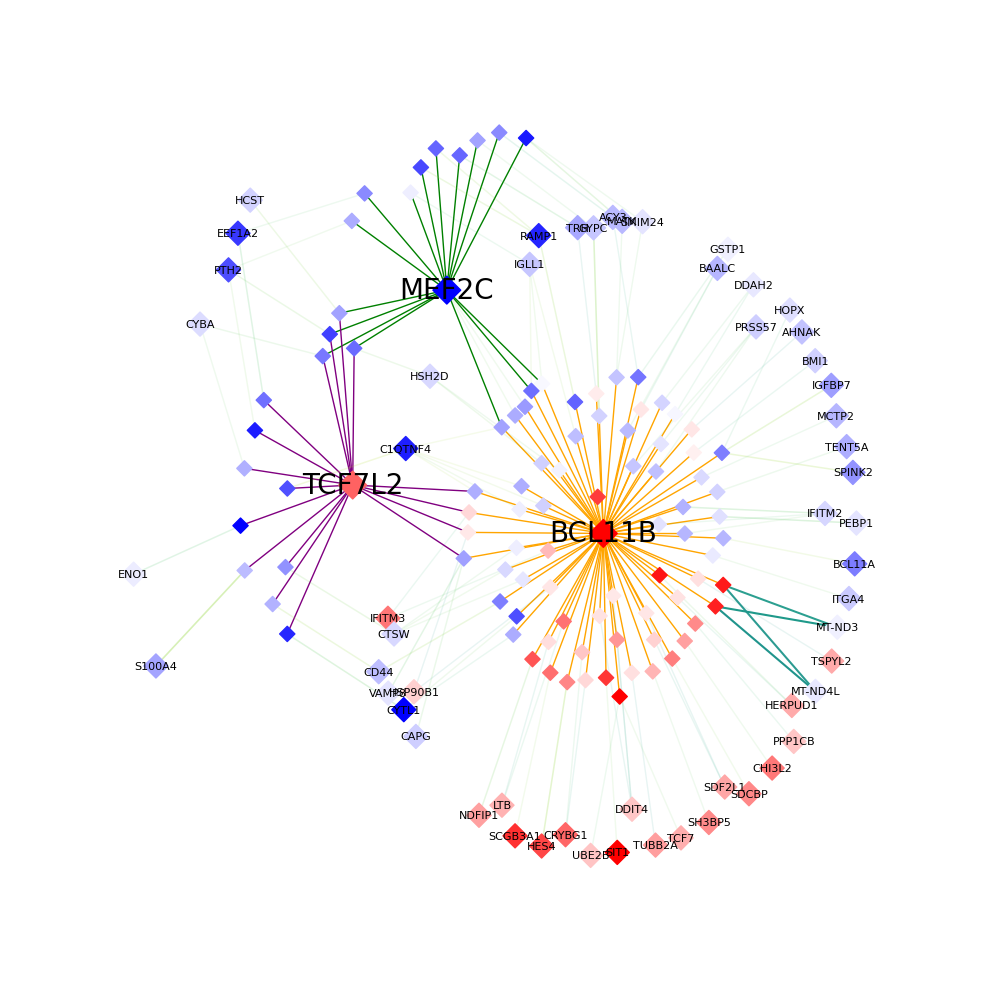

In [23]:
G, pos, edge_tables, node_tables = create_nx_graph(nx_tables,
                   use_edge_tables = ['TF2R','R2G'],
                   color_edge_by = {'TF2R': {'variable' : 'TF', 'category_color' : {'MEF2C': 'Green', 'BCL11B': 'Orange', 'TCF7L2': 'Purple'}},
                                    'R2G': {'variable' : 'rho_R2G', 'continuous_color' : 'viridis', 'v_min': -1, 'v_max': 1}},
                   transparency_edge_by =  {'R2G': {'variable' : 'importance_R2G', 'min_alpha': 0.1, 'v_min': 0}},
                   width_edge_by = {'R2G': {'variable' : 'importance_R2G', 'max_size' :  1.5, 'min_size' : 1}},
                   color_node_by = {'TF': {'variable': 'comparison.bmp.vs.t.specified_Log2FC_T-specified-R', 'continuous_color' : 'bwr'},
                                    'Gene': {'variable': 'comparison.bmp.vs.t.specified_Log2FC_T-specified-R', 'continuous_color' : 'bwr'},
                                    'Region': {'variable': 'comparison.bmp.vs.t.specified_Log2FC_T-specified-R', 'continuous_color' : 'bwr'}},
                   size_node_by = {'TF': {'variable': 'fixed_size', 'fixed_size': 200},
                                    'Gene': {'variable': 'fixed_size', 'fixed_size': 150},
                                    'Region': {'variable': 'fixed_size', 'fixed_size': 60}},
                   shape_node_by = {'TF': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Gene': {'variable': 'fixed_shape', 'fixed_shape': 'ellipse'},
                                    'Region': {'variable': 'fixed_shape', 'fixed_shape': 'diamond'}},
                   label_size_by = {'TF': {'variable': 'fixed_label_size', 'fixed_label_size': 20.0},
                                    'Gene': {'variable': 'fixed_label_size', 'fixed_label_size': 8},
                                    'Region': {'variable': 'fixed_label_size', 'fixed_label_size': 0.0}},
                   layout='kamada_kawai_layout',
                   scale_position_by=400)
plt.figure(figsize=(10,10))
plot_networkx(G, pos)

2024-05-08 16:27:25,973 fontTools.subset INFO     maxp pruned
2024-05-08 16:27:25,982 fontTools.subset INFO     cmap pruned
2024-05-08 16:27:25,983 fontTools.subset INFO     kern dropped
2024-05-08 16:27:25,983 fontTools.subset INFO     post pruned
2024-05-08 16:27:25,985 fontTools.subset INFO     FFTM dropped
2024-05-08 16:27:25,987 fontTools.subset INFO     GPOS pruned
2024-05-08 16:27:25,991 fontTools.subset INFO     GSUB pruned
2024-05-08 16:27:25,997 fontTools.subset INFO     glyf pruned
2024-05-08 16:27:25,998 fontTools.subset INFO     Added gid0 to subset
2024-05-08 16:27:25,999 fontTools.subset INFO     Added first four glyphs to subset
2024-05-08 16:27:26,000 fontTools.subset INFO     Closing glyph list over 'GSUB': 38 glyphs before
2024-05-08 16:27:26,001 fontTools.subset INFO     Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'eight', 'five', 'four', 'hyphen', 'nine', '

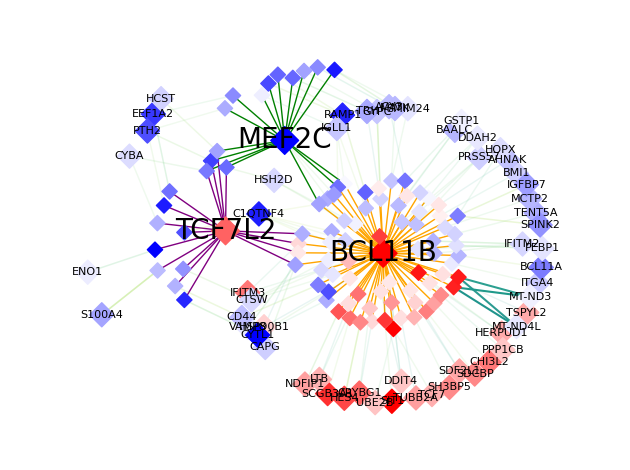

In [29]:
import networkx as nx
nx.draw_networkx_nodes(G, pos, node_color=nx.get_node_attributes(G,'color').values(),
                        node_size=list(nx.get_node_attributes(G,'size').values()),
                        node_shape = 'D')
nx.draw_networkx_edges(G, pos, edge_color = nx.get_edge_attributes(G,'color').values(),
                        width = list(nx.get_edge_attributes(G,'width').values()))
fontsize_d = {y:x['size'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
fontcolor_d = {y:x['color'] for x,y in zip(list(nx.get_node_attributes(G,'font').values()),list(nx.get_node_attributes(G,'label').values())) if x['size'] != 0.0}
for node, (x, y) in pos.items():
    if node in fontsize_d.keys():
        plt.text(x, y, node, fontsize=fontsize_d[node], color=fontcolor_d[node],  ha='center', va='center')
ax = plt.gca()
ax.margins(0.11)
plt.tight_layout()
plt.axis("off")
plt.savefig("BMPlike_TSpec_Network.pdf", bbox_inches='tight')
plt.show()